In [5]:
import numpy as np
import matplotlib.pyplot as plt
import emcee 
import corner
import pandas as pd

In [25]:
df = pd.read_csv('tmp_dt.csv')
df
x = df.dt * 12
y = df.mp
yerr = np.zeros(len(x))

In [26]:
def log_likelihood(theta, x, y, yerr):
    m, b, sig = theta
    model = m * x + b
    sigma2 = sig**2
    return -0.5 * np.sum((y - model)** 2 / sigma2 + np.log(sigma2))

In [27]:
from scipy.optimize import minimize
np.random.seed(42) # For some reason this only works with this particular seed

nll = lambda *args: -log_likelihood(*args) 
initial = np.array([-1, 180, 50]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, sig = soln.x

print("Maximum likelihood estimates:")
print(f"m = {m_ml} b = {b_ml} sig = {sig}")
print()


Maximum likelihood estimates:
m = -1.8223214577889701 b = 282.3474944678418 sig = 39.184678697142076



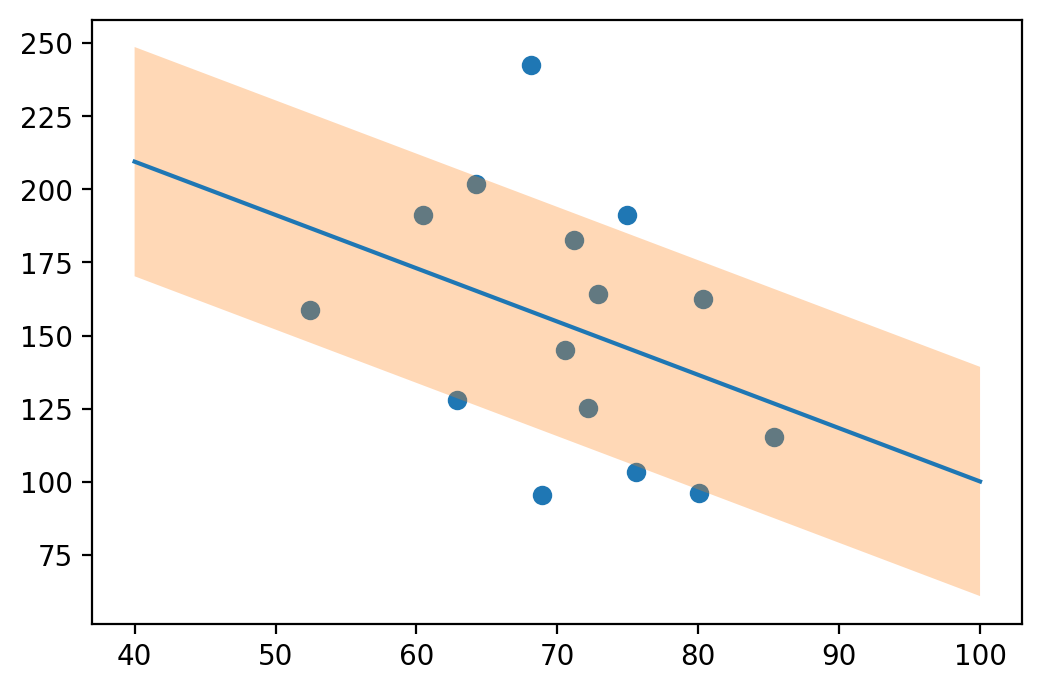

In [31]:
x_new = np.linspace(40, 100)

fig, ax = plt.subplots(dpi=200)
ax.scatter(x, y)
pred = m_ml * x_new + b_ml
ax.plot(x_new, pred) 

ax.fill_between(x_new, pred - sig, pred + sig, alpha = 0.3)

In [32]:
def log_prior(theta):
    m, b, sig = theta
    if -20.0 < m < 20.0 and -500.0 < b < 500.0 and 0.0 < sig < 200.0:
        return 0.0
    return -np.inf

In [33]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [42]:
import emcee

pos = soln.x + 1e-5 * np.random.randn(32, 3) # using the MLE model
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 4000, progress=True);

100%|███████████████████████████████████████| 4000/4000 [00:59<00:00, 66.68it/s]


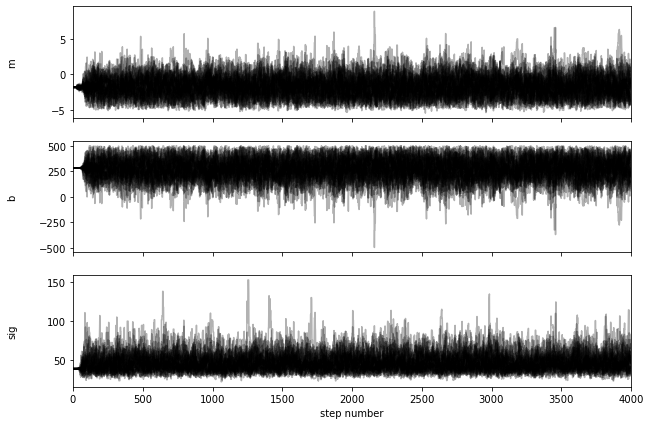

In [43]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "sig"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [44]:
tau = sampler.get_autocorr_time()
print(tau)


[38.74100985 38.33609017 39.07707709]


In [45]:
flat_samples = sampler.get_chain(discard=100, thin=25, flat=True)
print(flat_samples.shape)

(4992, 3)


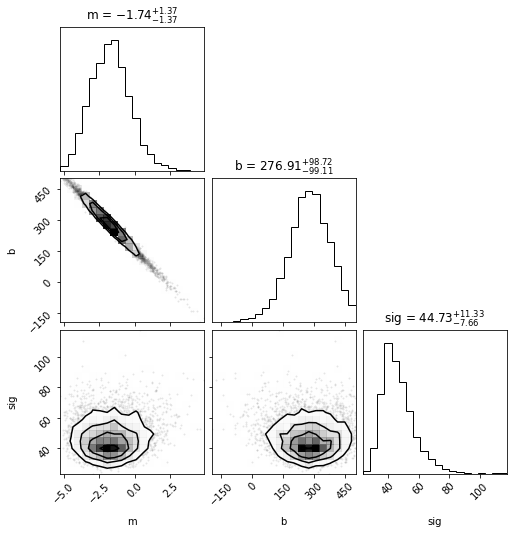

In [46]:
import corner

fig = corner.corner(
    flat_samples, labels=labels,
    show_titles=True
);

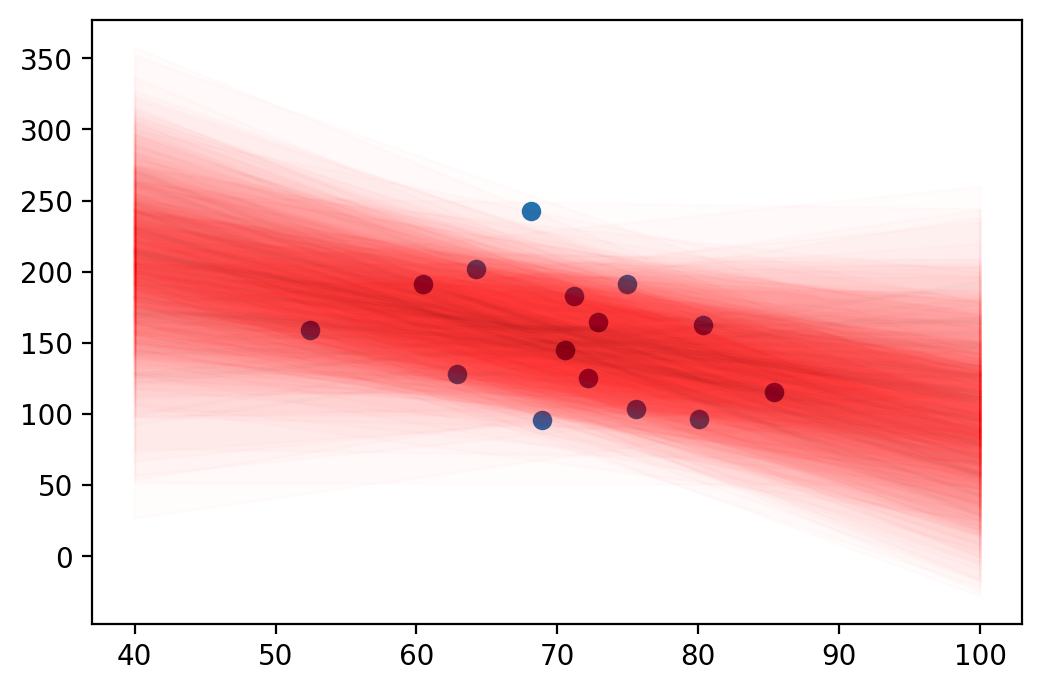

In [53]:
x_new = np.linspace(40, 100)

fig, ax = plt.subplots(dpi=200)
ax.scatter(x, y)

inds = np.random.randint(len(flat_samples), size=100) 
# which random walk we will be choosing
for ind in inds:
    sample = flat_samples[ind]
    pred = sample[0] * x_new + sample[1]
    ax.plot(x_new, pred, c='k', alpha=0.01) 

    ax.fill_between(x_new, pred - sample[2], pred + sample[2], 
                    alpha = 0.01, color='r')